## Produce the json file listing all profiles in GS region

In [1]:
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from datetime import date
import io
import json


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
latmin,latmax,lonmin,lonmax=(32.6,65.6,-17,10)
datemin,datemax=('2012-10-01','2013-09-30')
jsonfile='NATL60-CJM165_EU_y2012-2013.json'

In [3]:
!ls /scratch/cnt0024/hmg2840/albert7a/EN4/

20100101_prof.nc  20110110_prof.nc  20120119_prof.nc
20100102_prof.nc  20110111_prof.nc  20120120_prof.nc
20100103_prof.nc  20110112_prof.nc  20120121_prof.nc
20100104_prof.nc  20110113_prof.nc  20120122_prof.nc
20100105_prof.nc  20110114_prof.nc  20120123_prof.nc
20100106_prof.nc  20110115_prof.nc  20120124_prof.nc
20100107_prof.nc  20110116_prof.nc  20120125_prof.nc
20100108_prof.nc  20110117_prof.nc  20120126_prof.nc
20100109_prof.nc  20110118_prof.nc  20120127_prof.nc
20100110_prof.nc  20110119_prof.nc  20120128_prof.nc
20100111_prof.nc  20110120_prof.nc  20120129_prof.nc
20100112_prof.nc  20110121_prof.nc  20120130_prof.nc
20100113_prof.nc  20110122_prof.nc  20120131_prof.nc
20100114_prof.nc  20110123_prof.nc  20120201_prof.nc
20100115_prof.nc  20110124_prof.nc  20120202_prof.nc
20100116_prof.nc  20110125_prof.nc  20120203_prof.nc
20100117_prof.nc  20110126_prof.nc  20120204_prof.nc
20100118_prof.nc  20110127_prof.nc  20120205_prof.nc
20100119_prof.nc  20110128_prof.nc  20120206_p

In [4]:
def select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax,jsonfile):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/scratch/cnt0024/hmg2840/albert7a/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        if int(yearmin)+1 == int(yearmax):
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')
        else:
            for year in np.arange(int(yearmin)+1,int(yearmax)):
                for m in np.arange(1,13):
                    if m < 10:
                        list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+str(year)+'0'+str(m)+'.nc')
                    else:
                        list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+str(year)+str(m)+'.nc')
        print(list_filesEN4)

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()

        for f in np.arange(len(list_filesEN4)):
            fileEN4=list_filesEN4[f]
            print('Processing '+str(fileEN4))
            tfileEN4=diren4+fileEN4
            dsen4=xr.open_dataset(tfileEN4)
            laten4=dsen4['LATITUDE']
            lonen4=dsen4['LONGITUDE']
            dayen4=dsen4['JULD']
            refen4=dsen4['DC_REFERENCE']
            indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))
            prof_zone=[]
            tsecen4z=[]
            for ref in np.arange(len(indz[0])):
                dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                    prof_zone.append(indz[0][ref])
                    tsecen4z.append(tsecen4)

            for ref in np.arange(len(prof_zone)):
                if 'dictyml' in locals():
                    up={str(refen4[prof_zone[ref]].values):{'reference':str(refen4[prof_zone[ref]].values),'file':fileEN4,'profile no':int(prof_zone[ref]),'latitude':float(laten4[prof_zone[ref]].values),'longitude':float(lonen4[prof_zone[ref]].values),'date':str(dayen4[prof_zone[ref]].values)}}
                    dictyml.update(up)
                else:
                    dictyml={str(refen4[prof_zone[ref]].values):{'reference':str(refen4[prof_zone[ref]].values),'file':fileEN4,'profile no':int(prof_zone[ref]),'latitude':float(laten4[prof_zone[ref]].values),'longitude':float(lonen4[prof_zone[ref]].values),'date':str(dayen4[prof_zone[ref]].values)}}
                    
        with io.open(jsonfile, 'w', encoding='utf8') as outfile:
            outfile.write(str(json.dumps(dictyml, sort_keys=True,indent=4, separators=(',', ': '))))



In [5]:
select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax,jsonfile)

['EN.4.2.0.f.profiles.g10.201210.nc', 'EN.4.2.0.f.profiles.g10.201211.nc', 'EN.4.2.0.f.profiles.g10.201212.nc', 'EN.4.2.0.f.profiles.g10.201301.nc', 'EN.4.2.0.f.profiles.g10.201302.nc', 'EN.4.2.0.f.profiles.g10.201303.nc', 'EN.4.2.0.f.profiles.g10.201304.nc', 'EN.4.2.0.f.profiles.g10.201305.nc', 'EN.4.2.0.f.profiles.g10.201306.nc', 'EN.4.2.0.f.profiles.g10.201307.nc', 'EN.4.2.0.f.profiles.g10.201308.nc', 'EN.4.2.0.f.profiles.g10.201309.nc']
Processing EN.4.2.0.f.profiles.g10.201210.nc
Processing EN.4.2.0.f.profiles.g10.201211.nc
Processing EN.4.2.0.f.profiles.g10.201212.nc
Processing EN.4.2.0.f.profiles.g10.201301.nc
Processing EN.4.2.0.f.profiles.g10.201302.nc
Processing EN.4.2.0.f.profiles.g10.201303.nc
Processing EN.4.2.0.f.profiles.g10.201304.nc
Processing EN.4.2.0.f.profiles.g10.201305.nc
Processing EN.4.2.0.f.profiles.g10.201306.nc
Processing EN.4.2.0.f.profiles.g10.201307.nc
Processing EN.4.2.0.f.profiles.g10.201308.nc
Processing EN.4.2.0.f.profiles.g10.201309.nc


## Plot the locations of all profiles

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [4]:
    sourcefile=open(jsonfile,'rU',encoding='utf-8')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)
    list_profiles=infos.keys()

    all_lat=np.zeros((nb_profilesEN4))
    all_lon=np.zeros((nb_profilesEN4))
    
    for prof in np.arange(nb_profilesEN4):
        reference =  str(list(list_profiles)[prof])
        lat_prof = infos[reference]['latitude']
        lon_prof = infos[reference]['longitude']
        all_lat[prof]=lat_prof
        all_lon[prof]=lon_prof


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [5]:
len(all_lon)

28144

In [6]:
def map_profiles_from_jsonfile(all_lat,all_lon):
    


    fig=plt.figure(figsize=(10,15))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
#    ax.set_extent((lonmin, lonmax, latmin, latmax))
#    ax.coastlines(resolution="10m")
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.scatter(all_lon, all_lat, c='g', linewidth='0', s=18);
    plt.title('EN4 profiles in GS region in 2012-2013', size=20);
    plt.savefig('profiles_EU_period_NATL60.png')


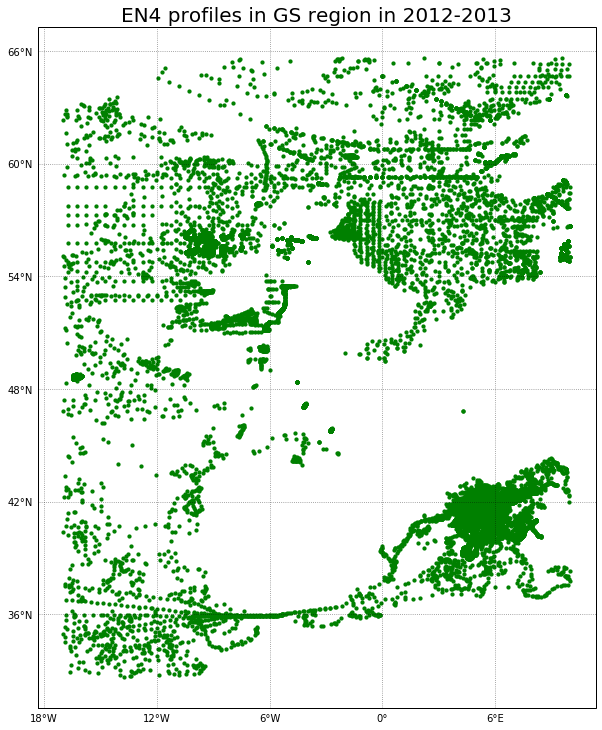

In [7]:
map_profiles_from_jsonfile(all_lat,all_lon)